SMOTE stands for Synthetic Minority Over-Sampling Technique, which creates synthetic examples for the minority class, for our example of binary classification it'll create synthetic data for our target feature which are the defeaulters of the next payments (IMG below). We'll use this as a way to balance the imbalanaced dataset and compare it to the imbalanced training done in "DS340_models.ipynb" and evaluate based on the same metrics.

Doc: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

![Fin](targetdistribution.png "")

In [2]:
!pip install imblearn

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Download dataset
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

/Users/popthrop/Desktop/DS 340/Final Project/DS340/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using two different "training data" to balance our target

In [3]:


# CSV file in the downloaded directory
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_file = os.path.join(path, file)
        break

df = pd.read_csv(csv_file)

target_vec = df['default.payment.next.month']
feature_vec = df.drop('default.payment.next.month', axis=1)

Baseline Model of Logistic Regression with Cross Validation

In [5]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SMOTE

x_train, x_test, y_train, y_test = train_test_split(feature_vec, target_vec, train_size=0.8)

LR_base = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegressionCV(
        cv=5,
        scoring='roc_auc',
        max_iter=5000,
        class_weight='balanced',
        solver="lbfgs",
        n_jobs=-1

    ))
])

LR_base.fit(x_train,y_train)
y_pred = LR_base.predict(x_test)

#Evaluations of all models will be based on AUC Score, Precision, Recall, and F score

precision, recall, fscore, _ = precision_recall_fscore_support(y_test,y_pred)

print(f'AUC Score: {LR_base.score(x_test,y_test)} \nPrecision: {precision} \nRecall: {recall} \n \
F Score: {fscore}')

AUC Score: 0.6984445415695416 
Precision: [0.85793034 0.37481334] 
Recall: [0.73162393 0.57045455] 
 F Score: [0.78975897 0.4523881 ]


Start to code more advanced ML techniques 

In [10]:
#Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameter_grid = {'RF__n_estimators': [10,100,200,500,1000]}

RF = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('RF', RandomForestClassifier(
        n_jobs=-1
    ))
    ])

RF_gridsearch = GridSearchCV(RF,param_grid=parameter_grid,scoring='roc_auc',cv=5,n_jobs=-1)

RF_gridsearch.fit(x_train,y_train)

y_pred = RF_gridsearch.predict(x_test)

#Evaluations of all models will be based on AUC Score, Precision, Recall, and F score

precision, recall, fscore, _ = precision_recall_fscore_support(y_test,y_pred)

print(f'AUC Score: {RF_gridsearch.score(x_test,y_test)} \nPrecision: {precision} \nRecall: {recall} \n \
F Score: {fscore}')


AUC Score: 0.7561557077182077 
Precision: [0.85488237 0.52046784] 
Recall: [0.87735043 0.4719697 ] 
 F Score: [0.86597068 0.49503377]


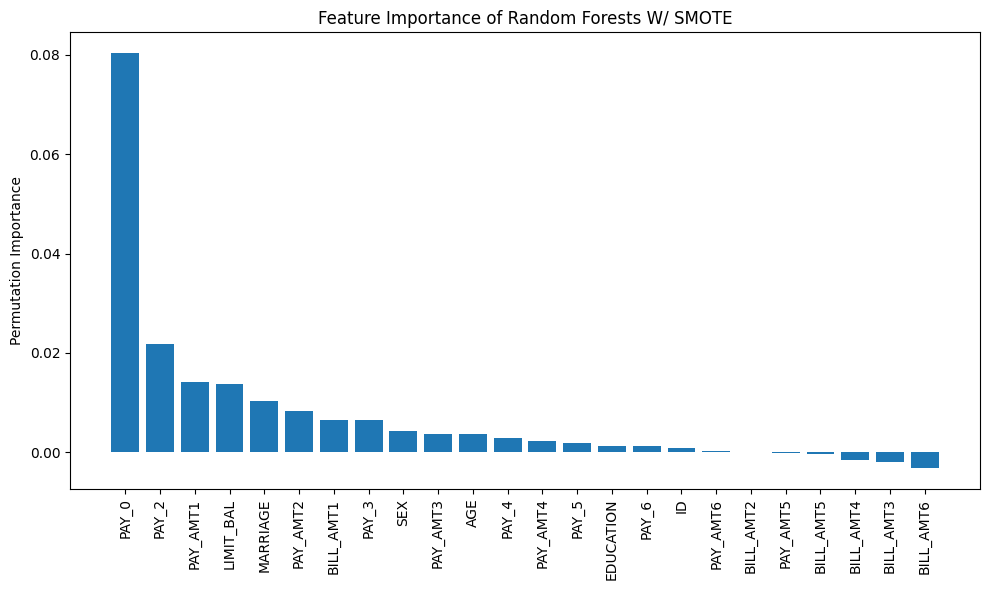

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(RF_gridsearch, x_test, y_test, n_repeats=15)
importances = result.importances_mean
feature_names = feature_vec.columns

sorted = np.argsort(importances)[::-1] #sort by descending

sorted_features = feature_names[sorted]
sorted_importances = importances[sorted]

plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances)
plt.xticks(rotation=90)
plt.ylabel("Permutation Importance")
plt.title("Feature Importance of Random Forests W/ SMOTE")
plt.tight_layout()
plt.show()